In [1]:
import numpy as np
from numpy.linalg import eigvals
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib qt5
#
#  extend path by location of the dvr package
#
import sys
sys.path.append('/home/thomas/Current_Work/Jolanta-by-dvr/Python_libs')
import dvr
import read_write

In [2]:
amu_to_au=1822.888486192
au2cm=219474.63068
au2eV=27.211386027
Angs2Bohr=1.8897259886

In [3]:
#
#  default 1D potential has a resonance just below 7 eV
#
def Jolanta_1D(x, a=0.2, b=0.0, c=0.14):
    return (a*x*x-b)*np.exp(-c*x*x)

#
#  default 3D potential has a resonance at 1.75 eV - 0.2i eV
#
def Jolanta_3D(r, a=0.1, b=1.2, c=0.1, l=1):
    return (a*r**2-b)*np.exp(-c*r**2) + 0.5*l*(l+1)/r**2

nGrid = 300
  1    0.01170180 au =      0.31842 eV
  2    0.03547063 au =      0.96521 eV
  3    0.06136177 au =      1.66974 eV
  4    0.08324826 au =      2.26530 eV
  5    0.13292595 au =      3.61710 eV
  6    0.19792627 au =      5.38585 eV


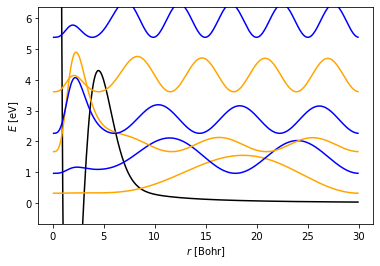

In [4]:
#
#  compute DVR of T and V
#  then show the density of states
#  in a potential + energy-levels plot
#
rmin=0
rmax=30      # grid from 0 to rmax
thresh = 5   # maximum energy for state in the plot in eV
ppB = 10     # grid points per Bohr

nGrid=int((rmax-rmin)*ppB)
print("nGrid = %d" % nGrid)
rs = dvr.DVRGrid(rmin, rmax, nGrid)
Vs = Jolanta_3D(rs, a=0.1, b=1.2, c=0.1, l=1)
Ts = dvr.KineticEnergy(1, rmin, rmax, nGrid)
[energy, wf] = dvr.DVRDiag2(nGrid, Ts, Vs)

n_ene=0
for i in range(nGrid):
    print("%3d  %12.8f au = %12.5f eV" % (i+1, energy[i], energy[i]*au2eV))
    n_ene += 1
    if energy[i]*au2eV > thresh:
        break

# "DVR normalization", sum(wf[:,0]**2)
# this is correct for plotting

c=["orange", "blue"]
#h=float(xmax) / (nGrid+1.0)
scale=150

plt.plot(rs,Vs*au2eV, '-', color="black")
for i in range(n_ene):
    plt.plot(rs, scale*wf[:,i]**2+energy[i]*au2eV, '-', color=c[i%len(c)])
plt.ylim(energy[0]*au2eV-1, energy[n_ene-1]*au2eV+1)
plt.xlabel('$r$ [Bohr]')
plt.ylabel('$E$ [eV]')
plt.show()

In [5]:
""" complex diagonalization example """

theta=40.0/180.0*np.pi

Vs = Jolanta_3D(rs*np.exp(1j*complex(theta)), a=0.1, b=1.2, c=0.1, l=1)
H_theta = np.exp(-2j*complex(theta)) * Ts + np.diag(Vs)
energies = eigvals(H_theta)
energies.sort()
energies[:10]*au2eV

array([-0.0586289  -5.25656195j, -0.02464396 -3.35638671j,
       -0.02436828 -7.66686727j,  0.02665461 -1.91931405j,
        0.0377573  -0.29914998j,  0.05471593 -0.91311125j,
        0.15257371-10.64207663j,  0.61492073-14.19015055j,
        1.60407346-17.84363933j,  1.75699568 -0.19929499j])

In [6]:
#
# above theta = 40 deg the lowest Re(E) are basis set 
# representation artifacts, and we should either not go there
# or use a better filter for the states to keep
#

In [7]:
#
#  complex scaling loop: 
#
#  start on the real axis (theta=0) and rotate to theta = theta_max 
#
#  we keep n_keep energies with the lowest real part 
#

n_theta=81
n_keep=16
theta_min=0
theta_max=40.0/180.0*np.pi

thetas=np.linspace(theta_min, theta_max, n_theta, endpoint=True)
run_data = np.zeros((n_theta,n_keep), complex)  # array used to collect all theta-run data

for i_theta in range(n_theta):
    theta=thetas[i_theta]
    Vs = Jolanta_3D(rs*np.exp(1j*complex(theta)), a=0.1, b=1.2, c=0.1, l=1)
    H_theta = np.exp(-2j*complex(theta)) * Ts + np.diag(Vs)
    energies = eigvals(H_theta)
    energies.sort()
    run_data[i_theta,:] = energies[0:n_keep]
    print(i_theta+1, end=" ")
    if (i_theta+1)%10==0:
        print()

run_data *= au2eV

1 2 3 4 5 6 7 8 9 10 
11 12 13 14 15 16 17 18 19 20 
21 22 23 24 25 26 27 28 29 30 
31 32 33 34 35 36 37 38 39 40 
41 42 43 44 45 46 47 48 49 50 
51 52 53 54 55 56 57 58 59 60 
61 62 63 64 65 66 67 68 69 70 
71 72 73 74 75 76 77 78 79 80 
81 

In [8]:
#run_data[0,1:8]

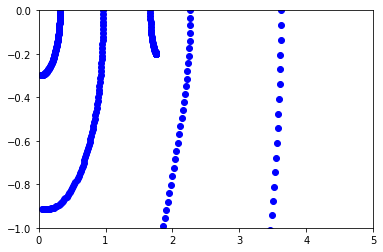

In [9]:
#
# useful piece of the complex plane 
# (if unknown, plot all and zoom with matplotlib)
#
for i in range(0, n_keep):
    plt.plot(run_data[:,i].real,  run_data[:,i].imag, 'o', color='blue')
plt.xlim(0,5)
plt.ylim(-1,0)
plt.show()

In [10]:
#
#
#  two follow ideas:
#
#   - at the last theta compute the angles and compare with 2*theta
#     if significantly smaller, then resonance
#
#   - once a trajectory has five values, use them
#     to establish a Pade[2,2]
#     then predict for the next theta
#
def follow_nearest(follow, es):
    """
    follow the energy closet to e0 from the real axis into the complex plane
    es is a table of theta-run data es[i_theta,j_energies]
    the algorithm used is simply nearest to the old energy
    """
    (n_thetas, n_energies) = es.shape
    trajectory = np.zeros(n_thetas,complex)
    for j in range(0,n_thetas):
        i = np.argmin(abs(es[j,:]-follow))
        follow = trajectory[j] = es[j,i]
    return trajectory

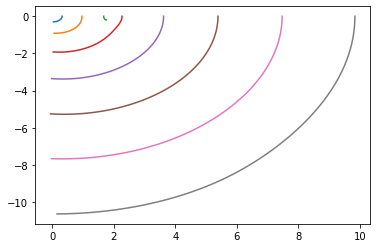

In [11]:
n_save = n_keep//2
trajectories = np.zeros((n_theta, n_save), complex)
for j in range(n_save):
    trajectories[:,j] = follow_nearest(run_data[0,j], run_data)
for i in range(0, n_save):
    plt.plot(trajectories[:,i].real,  trajectories[:,i].imag, '-')
plt.show()

In [14]:
#
#  save n_save trajectories to file
#  csv as real and imag 
#  (at the moment easier than csv with complex)
#  also, include no header, because the energies need to be sorted
#  into trajectories first
#
fname="complex_scaling_rmax."+str(int(rmax))+"_ppB."+str(ppB)+".csv"
read_write.write_theta_run(fname,thetas,trajectories)

In [15]:
#
# regarding the question of automatization:
# the resonance clearly stands out in CS/DVR
# use to make a loop over the Jolanata parameters 
# and map Eres(a,b,c) in a useful range: 0.1 to 8 eV
#
for i in range(n_save):
    print(i, np.angle(trajectories[-1,i],deg=True))

0 -82.80643512038972
1 -86.57079292511908
2 -6.47136708813543
3 -89.20435195520255
4 -90.42068144894559
5 -90.6390202184933
6 -90.1821075896935
7 -89.1786160796176


In [16]:
res_traj = trajectories[:,2]

In [17]:
def naive_derivative(xs, ys):
    """ naive forward or backward derivative """
    return (ys[1]-ys[0])/(xs[1]-xs[0])

def central_derivative(xs, ys):
    """ central derivative at x[1] """
    return (ys[2]-ys[0])/(xs[2]-xs[0])

def five_point_derivative(xs, ys):
    """ five-point derivative at x[2] """
    """ (-ys[0] + 8*ys[1] - 8*ys[3] + ys[4])/(12*h)  """
    return (-ys[0] + 8*ys[1] - 8*ys[3] + ys[4])/(xs[4]-xs[0])/3

In [18]:
abs_der = np.zeros(n_theta)
abs_der[0] = abs(naive_derivative(thetas[0:2], res_traj[0:2]))
abs_der[1] = abs(central_derivative(thetas[0:3], res_traj[0:3]))
for k in range(2,n_theta-2):
    abs_der[k] = abs(five_point_derivative(thetas[k-2:k+3], res_traj[k-2:k+3]))
abs_der[-2] = abs(naive_derivative(thetas[-3:], res_traj[-3:]))
abs_der[-1] = abs(naive_derivative(thetas[-2:], res_traj[-2:]))

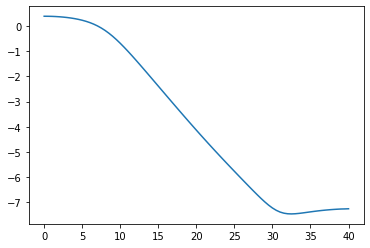

In [19]:
plt.cla()
plt.plot(thetas*180/np.pi, np.log(abs_der))
plt.show()

In [23]:
#
#  get a feeling for the stabilitity of the value
#
j_opt = np.argmin(abs_der)
print(j_opt, thetas[j_opt]*180/np.pi)
print(res_traj[j_opt])
print(res_traj[j_opt-1]-res_traj[j_opt])
print(res_traj[j_opt+1]-res_traj[j_opt])

65 32.5
(1.7569135282170232-0.19930673068659482j)
(-4.711594967288235e-06+1.658790630576501e-06j)
(4.855752281374137e-06-1.187225690119087e-06j)
